### Introduction

Simon's problem is an instance of a computational task where a probabilistic quantum algorithm can solve the problem exponentially faster than any known probabilistic classical algorithm. Unlike algorithms such as [Deutsch–Jozsa](https://sohrabganjian.github.io/blog/2025/deutsch-jozsa-algorithm/), which are deterministic, Simon’s algorithm produces the correct result with high probability, requiring multiple runs and classical post-processing to recover the solution, which makes it an instance of a hybrid quantum-classical algorithm.

In this notebook, we define the problem statement, present the quantum algorithm, and explain the classical post-processing step used to extract the hidden string. The quantum query complexity of Simon's algorithm is $\mathcal{O}(n)$. However, the algorithm relies on a classical post-processing step, solving a system of linear equations, which has an upper bound complexity of $\mathcal{O}(n^3)$. As such, the overall runtime is dominated by this classical step, though the quantum component remains efficiently scalable. We also examine the classical approach to solving Simon's problem, which reduces to a collision-finding task analogous to the Birthday Paradox, and requires $\mathcal{O}(2^{n/2})$ queries to expect a collision.

Finally, we explore a concrete example of a function that satisfies the conditions of Simon’s problem, implement a quantum circuit that encodes this function, and demonstrate how the solution can be recovered using classical post-processing.

### Table of Contents

1. Problem Statement (Textbook version)
2. Simon's Algorithm
3. Proof of Correctness
4. Solving for the Secret $s$
5. Classical Complexity
6. Example
7. Conclusion

### Appendices
8. Appendix 1: Biography
9. Appendix 2: References and Suggested Readings

---
### Problem Statement (Textbook version)

Given an oracle $f:\{ 0,1 \}^n \rightarrow \{ 0,1 \}^n$, which satisfies exactly one of the following two promises:

 - $f$ is one-to-one or injective. That is, every input maps to exactly one output.
 - There exists a non-zero secret string $s \in \{ 0,1 \}^n$ such that for all distinct $x,y \in \{ 0, 1\}^n$
$$f(x) = f(y) \Leftrightarrow x \oplus s = y.$$

The task is to determine which case holds, and if the second case applies, to find the secret string $s$.  

Simon’s original paper actually allows the output register to be longer:
$$
f : \{0,1\}^n \rightarrow \{0,1\}^m, \qquad m \ge n.
$$
The same promise structure applies; the algorithm and its complexity do not fundamentally change when the codomain has $m$ bits instead of $n$.


Additionally, in the orignal paper, the function $f$ is described as being *invariant under some XOR-mask*. (See [page 14](https://www.cs.columbia.edu/~rocco/Public/SG_041291_2.pdf) of this document.) 

A function $f(x)$ is said to be invariant if there exists a non-trivial ($s \neq 0$) bitstring $s \in \{ 0,1 \}^n$ such that for all inputs $x,x' \in \{ 0,1 \}^n$:
$$
f(x') = f(x) \quad \text{ if and only if } \quad x' = x \oplus s
$$
The bitstring $s$ is referred to as the XOR-mask that defines the function's invariance property. 

What does it mean? 

If $f(x)$ is invariant under an XOR-mask $s$, then the function’s output remains the same when the input is XORed with $s$. That is, $f(x) = f(x \oplus s)$ for all $x$, and these are the only collisions allowed.

---
### Simon's Algorithm

1. **Initialization**: Initialzie two $n$-qubit registers in the $|0\rangle$ to obtain the state:
   $$|\psi_0\rangle = |0\rangle^{\otimes 2n}$$ 
2. **Hadamard Transformation**: Apply Hadamard gates on the first $n$ registers:
   $$|\psi_1\rangle = [H^{\otimes n} \otimes I^{\otimes n}] |\psi_0 \rangle$$
3. **Oracle Query**: The oracle $U_f$ is applied, performing the transformation:
   $$|\psi_2\rangle = U_f |\psi_1 \rangle$$
3. **Hadamard Transformation**: Applying Hadamard gates to the first $n$ qubits again:
    $$|\psi_3\rangle = [H^{\otimes n} \otimes I^{\otimes n}] |\psi_2 \rangle$$
4. **Measurement**: The first $n$ registers are measured in the computational basis.
5. **Post-Measurement Process**: Steps 1–4 are repeated $\mathcal{O}(n)$ times. After the measurements, classical post-processing is required to determine whether $f$ is one-to-one or two-to-one. In the latter case, the procedure will reveal the secret string $s$.

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.visualization import circuit_drawer
from qiskit_aer import Aer
from qiskit.circuit import Gate

import random
import numpy as np
import galois

import sympy
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'serif'

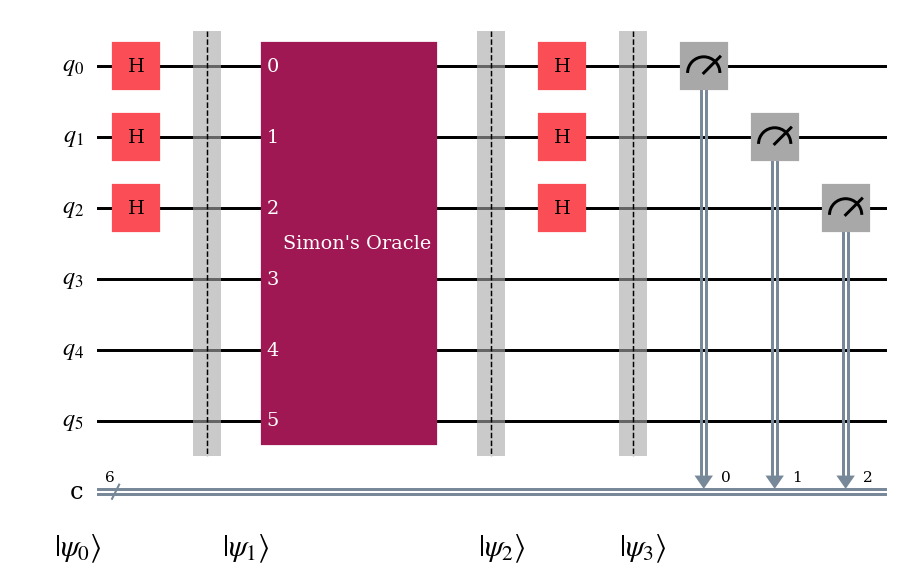

In [2]:
n = 3
qc = QuantumCircuit(2 * n, 2 * n)

qc.h(range(n))
qc.barrier()

oracle_gate = Gate(name="Simon's Oracle", num_qubits=2 * n, params=[])
qc.append(oracle_gate, range(2 * n))
qc.barrier()

qc.h(range(n))
qc.barrier()
qc.measure(range(n), range(n))


fig, ax = plt.subplots(figsize=(12, 7))  


circuit_drawer(qc, output='mpl', ax=ax, scale=0.6, idle_wires=False)  

y_coord_annotation = -0.04
ax.annotate(r"$|\psi_0\rangle$", xy=(0.05, y_coord_annotation), xycoords="axes fraction", fontsize=22, color="black", fontweight="bold")
ax.annotate(r"$|\psi_1\rangle$", xy=(0.24, y_coord_annotation), xycoords="axes fraction", fontsize=22, color="black", fontweight="bold")
ax.annotate(r"$|\psi_2\rangle$", xy=(0.53, y_coord_annotation), xycoords="axes fraction", fontsize=22, color="black", fontweight="bold")
ax.annotate(r"$|\psi_3\rangle$", xy=(0.69, y_coord_annotation), xycoords="axes fraction", fontsize=22, color="black", fontweight="bold")


plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.85)  

plt.show()

---
### Proof of Correctness

We begin by initialzing the system in the all zero state: 
$$
|\psi_0\rangle = |0\rangle^{\otimes 2n}
$$

$$
\begin{aligned}
\left[H^{\otimes n} \otimes I^{\otimes n} \right] |\psi_0 \rangle^{\otimes 2n} &= 
\frac{1}{\sqrt{2}^n} \sum\limits_{x \in \{ 0,1\}^n} |x\rangle |0\rangle^{\otimes n}  \\
&= |\psi_1\rangle
\end{aligned}
$$

$$
\begin{aligned}
U_f |\psi_1 \rangle &= U_f \left[ \frac{1}{\sqrt{2}^n} \sum\limits_{x \in \{ 0,1\}^n} |x\rangle |0\rangle^{\otimes n} \right] \\
&= \frac{1}{\sqrt{2}^n} \sum\limits_{x \in \{ 0,1\}^n} |x\rangle |f(x) \rangle
\end{aligned}
$$

$$
= \frac{1}{\sqrt{2}^n} \left[ 
|00 \dots 0 \rangle |f(00 \dots 0 ) \rangle + 
|00 \dots 1 \rangle |f(00 \dots 1 ) \rangle + 
\dots +
|11 \dots 1 \rangle |f(11 \dots 1 ) \rangle
\right]
$$

Suppose $s \neq 0$: 

Now for a given $x \in \{ 0,1 \}^n,  \exists x \oplus s \neq x$ such that $f(x) = f(x \oplus s)$. We define the equivalence relationship $\sim_{\text{Simon}}$ as:
$$
x \sim_{\text{Simon}} y \Leftrightarrow y = x \oplus s 
$$
We have $\{ 0,1 \}^n / \sim_{\text{Simon}} = \{ [x] | x \in \{0,1\}^n \}$. Suppose we label such represtnation as $[x_1], [x_2], \dots, [x_{2^{n-1}}]$. 
Therefore, we can write:
$$
= \frac{1}{\sqrt{2}^n} \left[ 
| x_1 \rangle |f( x_1 ) \rangle + 
|x_1 \oplus s \rangle |f( x_1 ) \rangle + 
\dots +
| x_{2^{n-1}} \rangle |f( x_{2^{n-1}} ) \rangle + 
|x_{2^{n-1}} \oplus s  \rangle |f( x_{2^{n-1}}  ) \rangle 
\right]
$$

$$=\frac{1}{\sqrt{2}^n} \sum\limits_{x_i \in \{ 0,1 \}^n / \sim_\text{Simon}} \left( |x_i \rangle |f(x_i) + |x_i \oplus s \rangle | f(x_i) \rangle \right) = |\psi_2\rangle$$

We now apply Hadamard gates to the first $n$ qubits:

$$H^{\otimes n} |x_i\rangle = \frac{1}{\sqrt{2}^n} \sum\limits_{y \in \{0,1\}^n} \left(-1 \right)^{x \cdot y} |y\rangle  $$
$$H^{\otimes n} |x_i \oplus s \rangle = \frac{1}{\sqrt{2}^n} \sum\limits_{y \in \{0,1\}^n} \left(-1 \right)^{(x \oplus s) \cdot y} |y\rangle  $$

Hence,
$$
\begin{aligned}
[H^{\otimes n} \otimes I^{\otimes n}] |\psi_2 \rangle
&= \frac{1}{2^n} \sum\limits_{y \in \{ 0,1 \}^n} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \left[ 
    \left( -1 \right)^{x \cdot y} |y \rangle | f(x) \rangle + \left( -1 \right)^{(x \oplus s) \cdot y} |y\rangle  |f(x) \rangle
\right] \\
&= \frac{1}{2^n} \sum\limits_{y \in \{ 0,1 \}^n} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \left[ 
    \left( \left( -1 \right)^{x \cdot y} |y \rangle | f(x) \rangle \right)  \left[ 1 + \left( -1 \right)^{s \cdot y} \right]
\right]
\end{aligned}
$$

Note that $s \cdot y = 1$ or $0$. If $s \cdot y = 1$, then the term $1+(-1)^{s \cdot y} = 1+(-1)^1 = 1 - 1 =0$. 

On the other hand if $s \cdot y = 0$, then $1+(-1)^{s \cdot y} = 1+(-1)^0 = 1+1 = 2$. Hence, 

$$
= \frac{1}{2^n} \sum\limits_{y \in \{ 0,1 \}^n}  \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} 2 \left[ 
    \left( \left( -1 \right)^{x \cdot y} |y \rangle | f(x) \rangle \right)  
\right]
= \frac{2}{2^n} \sum\limits_{y \in \{ 0,1 \}^n}  \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \left[ 
    \left( \left( -1 \right)^{x \cdot y} |y \rangle | f(x) \rangle \right)  
\right]
= \frac{1}{2^{n-1}} \sum\limits_{y \in \{ 0,1 \}^n}  \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \left[ 
    \left( \left( -1 \right)^{x \cdot y} |y \rangle | f(x) \rangle \right)  
\right]
$$

The probabiliy of observing $y$ becomes:
$$
P(y) = \left\| \frac{1}{2^{n-1}} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} (-1)^{x \cdot y} |f(x) \rangle  \right\|^{2}
$$

Recall that the squared norm of a quantum state $\| |\phi \rangle \| = \langle \phi | \phi \rangle$. Hence, 

$$
\begin{aligned}
P(y) &= \left\| \frac{1}{2^{n-1}} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} (-1)^{x \cdot y} |f(x) \rangle  \right\|^{2} \\
&= \frac{1}{2^{2(n-1)}} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \sum\limits_{x' \in \{ 0,1 \}^n / \sim_\text{Simon}} (-1)^{x \cdot y} (-1)^{x' \cdot y} \langle f(x) | f(x) \rangle
\end{aligned}
$$

For distinct equivalence classes $[x] \neq [x'], f(x) \neq f(x')$, so 
$$
\langle f(x) | f(x) \rangle = \delta_{f(x), f(x')} =
\begin{cases}
1 \quad &\text{if } [x] = [x'], \\
0 &\text{otherwise}. 
\end{cases}
$$
Therefore, 
$$
\begin{aligned}
P(y) &= \frac{1}{2^{2(n-1)}} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \sum\limits_{x' \in \{ 0,1 \}^n / \sim_\text{Simon}} (-1)^{x \cdot y} (-1)^{x' \cdot y} \langle f(x) | f(x) \rangle \\
&= \frac{1}{2^{2(n-1)}} \sum\limits_{x \in \{ 0,1 \}^n / \sim_\text{Simon}} \underbrace{\left( -1 \right)^{x \cdot y} \left( -1 \right)^{x \cdot y}}_{=1} \underbrace{\langle f(x) | f(x) \rangle}_{= 1}
 \\
&= \frac{1}{2^{n-1}} \cdot 2^{n-1}  \\
&= \frac{1}{2^{n-1}}. 
\end{aligned}
$$

Therefore, the measurement outcomes $y$ are uniformly distributed among the $2^{n-1}$ possible choices. Moreover, when $s \neq 0$ the measured string $y$ is guaranteed to satisfy the condition $s \cdot y = 0$.  

If $s = 0$, then the measurement yield a uniform $n$-bit string $y$ with probability $P(y) = \frac{1}{2^n}$.

---
### Solving for the Secret $s$

Analysis of $s \neq 0$: 

Measuring an instance of $y$ such that $s \cdot y = 0$ does not fully reveal $s$. To completely determine $s$, we need $n - 1$ linearly independet values of y. We then solve a system of $n-1$ homogeneous linear equations over $\mathbb{Z}_2$. Repeated measurements yield different values of $y$, and with high probability, we obtain $n-1$ linearly independent equations. 

$$
\DeclareMathOperator{\rank}{rank}
\DeclareMathOperator{\span}{span}
$$

We would like to answer the question: "What is the probability of measuring $n-1$ linearly independent equations?"

To answer this question, let's first consider a simpler problem: Suppose we have a measured the first vector $y^{(1)} \neq 0$. What is the probability that $y^{(2)}$ is independent of $y^{(1)}$?. 

In total, there are $2^{n-1}$ possible choices for $y$. The span of $y^{(1)}$ consists of two elements: 
$$
\span\left\{ y^{(1)} \right\} = \{ 0, y^{(1)} \}.
$$
Thus, the probability that $y^{(2)}$ depends on $y^{(1)}$ is given by: 
$$
P\left(y^{(2)} \in \span \left\{ y^{(1)} \right\} \right) = \frac{2}{2^{n-1}} = \frac{1}{2^{n-2}}. 
$$
Hence, the probability that $y^{(2)}$ is independent of $y^{(1)}$ is: 
$$
P\left(y^{(2)} \not\in \span \left\{ y^{(1)} \right\} \right) = 1 - \frac{1}{2^{n-2}} = \frac{2^{n-2} - 1}{2^{n-2}}
$$

Continuting similarly, the probability that $y^{(3)}$ is independent of the span of $\{ y^{(1)}, y^{(2)} \}$ is: 

$$
P \left(y^{(3)} \not\in \span \left\{  y^{(1)}, y^{(2)}  \right\} \right) = 1 - \frac{2^2}{2^{n-1}} = 1 - \frac{1}{2^{n-3}}.
$$ 

Now, instead of asking: "Given $k$ linearly independent vectors, what is the probability the $(k+1)$-th vector is also indepnednt?", which is: 
$$P\left( y^{k+1} \not\in \span \left\{ y^{(1)}, \dots, y^{(k)} \right\} \right) = 1 - \frac{2^{k}}{2^{n-1}},$$ 
we would like to answer: "What is the probability of measuring $k+1$ linearly indepedndent vectors?". Notice the subtle difference between the two questions, which have drastically different answers! 

To answer the latter question, we need to answer the following questions:

1. What is the probability of having $k$ independent vectors?
2. Given the first $k$ vectors are independent, what is the conditional probability that the $k+1$-th vector is linearly independent?  

Mathematically:

$$P(k+1 \text{ indep.}) = P(k \text{ indep.}) \cdot P(y^{k+1} \text{ indep.} | y^{(1)}, \dots, y^{(k)} \text{ indep.}) $$


Generally speaking, for sequential events, $A_1, A_2, \dots, A_{k+1}$, where each $A_i$ depends on prior events: 
$$
P\left( \bigcap\limits_{i=1}^{k+1} A_i \right) 
= 
P(A_1) \cdot P(A_2 | A_1) \cdot P (A_3 | A_1 \cap A_2) \cdots P\left( A_{k+1} | \bigcap\limits_{i=1}^k A_i \right). 
$$

Letting $A_i$ denote that the $i$th measured vector is independent from the previous ones, we obtain:  

$$
\begin{aligned}
P\left( \bigcap\limits_{i=1}^{k+1} A_i \right) 
&= 
\underbrace{P(A_1)}_{= 1 - \frac{1}{2^{n-1}}} \cdot \underbrace{P(A_2 | A_1)}_{= 1 - \frac{2}{2^{n-1}}} \cdot \underbrace{P (A_3 | A_1 \cap A_2)}_{= 1 - \frac{2^2}{2^{n-1}}} \cdots \underbrace{P\left( A_{k+1} | \bigcap\limits_{i=1}^k A_i \right)}_{=  1 - \frac{2^{k}}{2^{n-1}} }.  \\
&= \prod\limits_{i=1}^{k-1} \left( 1 - \frac{2^{i-1}}{2^{n-1}} \right). 
\end{aligned}
$$
Specifically, to measure exactly $(n-1)$ independent vectors, the probability is:
$$
P \left( \bigcap\limits^{n-1}_{i=1} A_i \right) = \prod\limits_{ i = 1 }^{ n - 1 } \left( 1 - \frac{2^{i-1}}{2^{n-1}} \right)
.$$

We can see the first few value of this product for different value of $n$. 

In [3]:
n = sympy.symbols('n')
k = sympy.symbols('k')

product_expr = sympy.Product(1 - ( 2**(k-1)/2**(n-1)), (k, 1, n-1))

values_n = list(range(2,10))
results = {n_val: product_expr.subs(n, n_val).doit() for n_val in values_n}

df = pd.DataFrame(list(results.items()), columns = ['n', 'Product Value'])
df = df.set_index("n")

df["Decimal Approxmiation"] = df['Product Value'].apply(lambda x:x.evalf(5))

df

,Product Value,Decimal Approxmiation
n,,
2,1/2,0.50000
3,3/8,0.37500
4,21/64,0.32813
5,315/1024,0.30762
6,9765/32768,0.29800
7,615195/2097152,0.29335
8,78129765/268435456,0.29106
9,19923090075/68719476736,0.28992


By results from mathematics, $\lim\limits_{n \rightarrow \infty} \prod\limits_{k=1}^{n-1} \left( 1 - \frac{2^{k-1}}{2^{n-1}} \right) = 0.288788\dots$. This equation appears in [Euler Function](https://en.wikipedia.org/wiki/Euler_function), [$q$-Puchhammer symbol](https://en.wikipedia.org/wiki/Q-Pochhammer_symbol), [Pentagonal Number Theorem](https://en.wikipedia.org/wiki/Pentagonal_number_theorem), and [Dedekin $\eta$-Function](https://en.wikipedia.org/wiki/Dedekind_eta_function). 

see: https://people.engr.tamu.edu/andreas-klappenecker/csce640-f14/simon2.pdf

That means that the probability of forming a $n-1$ linearly independet vectors from $n-1$ measurements is slightly more than $25\%$. Intuitively, with more measurements, this likelihood increases. Therefore, we need to ask "What is the probability of observing a set of $n-1$ linearly independent vetors from a set of $M$ vectors, where $M \geq n-1$?". 

With a bit of a rearrangmenet we can show that 
$$
\begin{aligned}
\prod\limits_{i=1}^{n-1} \left( 1 - \frac{2^{i-1}}{2^{n-1}} \right)
&= 
\prod\limits_{i=1}^{n-1} \left( 1 - \frac{1}{2^{n-1 - i + 1}} \right) \\
&= 
\prod\limits_{i=1}^{n-1} \left( 1 - \frac{1}{2^{n - i}} \right) \\
&= 
\prod\limits_{j=0}^{n-2} \left( 1 - \frac{1}{2^{n - 1 - i}} \right) \quad ( \ast )  \\
\end{aligned}
$$

We can generalize this formula to compute the probability that $M \geq n-1$ uniformly sampled vectors span the entire space. The expression is:
$$
\prod\limits_{j=0}^{n-2} \left( 1 - \frac{1}{2^{M-j}} \right)
$$
This reduces to equation $(\ast)$ when $M = n - 1$. It does depend on $M$, and as $M$ increases, each term $\frac{1}{2^{M- j}} \to 0$. Hence, the probability approaches $1$ as $M \gg n-1 \geq j$. 

<!-- $\frac{n-1 \text{ linearly indepednt vectors}}{\text{Total number of ways of possible outcomes}} = \dots$ 

Each vector is chosen uniformly from a subspace of dimension $n-1$, hence there are 
$$
2^{n-1}
$$
possible outcomes for each draw. We are doing this $M$ times, hence there are 
$$
\underbrace{2^{n-1} \times 2^{n-1} \times \cdots \times 2^{n-1}}_{M \text{ times}} = \left( 2^{n-1} \right)^M 
$$
total ways to pick M vectors. So that counts the total number of way of possible outcomes. 

Due to the constraints $s \cdot y = 0$, the solution space is an $n-1$-dimensional space. This constraint is equivalent to requiring that $y$ lies in the orthogonal complement of the subspace spanned by $s$. Note that while the solution is an $n$-dimensional vector that exists in $F_{2}^{n}$, but we are interested in a subspace of $F_2^n$ with dimension $n-1$. This subspace is isomorphic to vector space $F_2^{n-1}$ but embedded in $F_2^n$. 

We make $M$ measuremnts independently and uniformly at random. We denote these vectors by $\{ v_1, v_2, \dots, v_M \}$. We want the probability that these $M$ vectors span (or "have rank =") the entire space dimension $n-1$. 

In this $n-1$ dimensional space, we have the following complement relation:

$$
P[\rank(\{v_i\}) = n-1] = 1 - P[\rank ( \{ v_i \} ) < n - 1]. 
$$

In other words, we either have "rank exactly $n-1$" or "rank at most (n-2)".  

To compute $P[\rank ( \{ v_i \} ) < n - 1]$, we first need to answer the question "How many subspaces for a fixed $d < n - 1$ exists?". The answer to this question comes from [Gaussian binomial coefficient](https://en.wikipedia.org/wiki/Gaussian_binomial_coefficient) given by:
$$
\begin{bmatrix}
n \\
k
\end{bmatrix}_q = \frac{\left( 1 - q^{n} \right) \left( 1 - q^{n-1} \right) \cdots \left( 1 - q^{n-d+1} \right) }{\left( 1 - q \right) \left( 1 - q^{2} \right) \cdots \left( 1 - q^{d} \right) }
$$

> The Gaussian binomial coefficient ... is a polynomial in q with integer coefficients, whose value when $q$ is set to a prime power counts the number of subspaces of dimension $d$ in a vector space of dimension $n$ over $F_q$, a finite field with q elements. 

Note that for $q=2$, we have: 

$$
\begin{aligned}
\begin{bmatrix}
n-1 \\
k
\end{bmatrix}_2 &= \frac{\left( 1 - 2^{n-1} \right) \cdots \left( 1 - 2^{n-1-d+1} \right) }{\left( 1 - 2 \right) \left( 1 - 2^{2} \right) \cdots \left( 1 - 2^{d} \right) } \\
&= \frac{\left[ (-1) (2^{n-1}-1) \right] \cdots \left[ (-1) (2^{n-d}-1) \right] }{\left[ (-1) (2-1) \right] \left[ (-1) (2^2-1) \cdots \left[ (-1) (2^d-1) \right] \right] } \\
&= \frac{ (-1)^d (2^{n-1}-1) \cdots (2^{n-d}-1)  }{ (-1)^d (2-1) (2^2-1) \cdots (2^d-1) } \\
&= \frac{2^{n-1}-1}{2^d-1} \cdots \frac{2^{n-d}-1}{2-1} \\
&= \prod\limits_{k=0}^{d-1} \frac{2^{n-1-k} - 1}{2^{d-k}-1} \\
&= \prod\limits_{k=0}^{d-1} \frac{2^k (2^{n-1-k} - 1) }{2^k (2^{d-k} - 1)} \\
&= \prod\limits_{k=0}^{d-1} \frac{2^{n-1} - 2^k}{2^d - 2^k}
\end{aligned}
$$

So far we have counted the number of $d$-dimensional subspaces given by the Gaussian binomial coefficient. However, we want to count the total number of sequences of $M$ vectors that lie entirely within any $d$-dimensional subspace of the $(n-1)$-dimensional space. Therefore, we have to answer the question "How many ways $M$ vectors can lie within one such subspace?". For each vector, there are $2^d$ possible choices. There are $M$ positions, therefore, the number of $M$ vectors that lie entirely within each $d$-dimensional subspace   
$$
\underbrace{2^d \times 2^d \times \dots \times 2^d}_{M} = 2^{dM}
$$

Thus, the total number of sequences of $M$ vectors that lie entirely within any $d$-dimensional subspace of the  $(n-1)$-dimensional space is:
$$
\text{ the number of $d$-dimensional subspaces } \times \text{ the number of $M$ vectors that lie entirely within each $d$-dimensional subspace } = \begin{bmatrix}
n-1 \\
k
\end{bmatrix}_2 \times 2^{dM}
$$ -->

In [4]:
results = []

for n in range(2, 11):
    M1 = n - 1
    M2 = n + 3

    product_M1 = 1
    for j in range(n - 1):
        product_M1 *= (1 - 1 / (2 ** (M1 - j)))

    product_M2 = 1
    for j in range(n - 1):
        product_M2 *= (1 - 1 / (2 ** (M2 - j)))

    results.append({
        'n': n,
        'M = n - 1': float(product_M1),
        'M = n + 3': float(product_M2)
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index("n")
results_df

,M = n - 1,M = n + 3
n,,
2,0.500000,0.968750
3,0.375000,0.953613
4,0.328125,0.946163
5,0.307617,0.942467
6,0.298004,0.940626
7,0.293348,0.939708
8,0.291056,0.939249
9,0.289919,0.939020
10,0.289353,0.938905


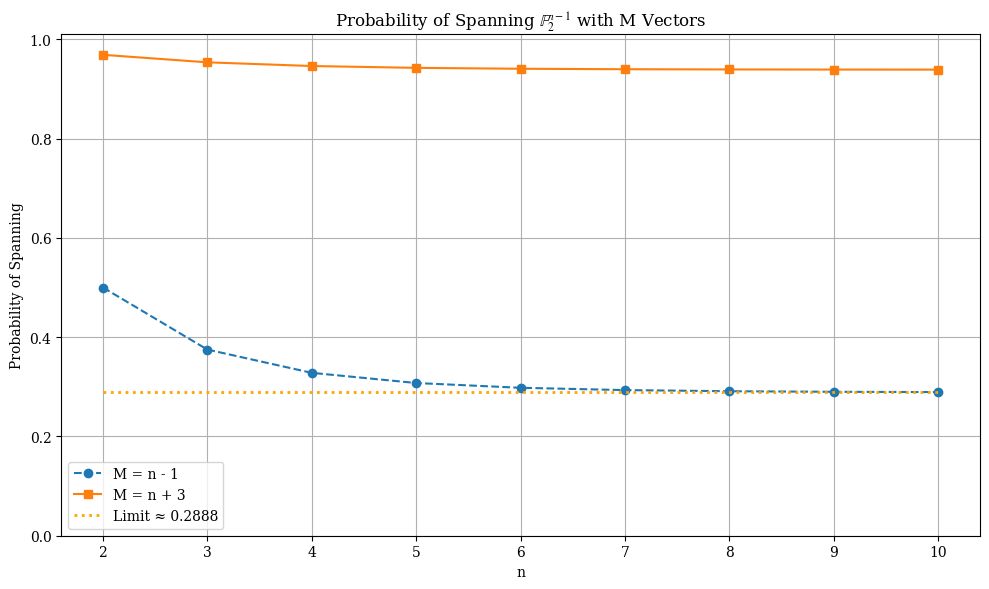

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot both curves
plt.plot(results_df.index, results_df['M = n - 1'], marker='o', label='M = n - 1', linestyle='--')
plt.plot(results_df.index, results_df['M = n + 3'], marker='s', label='M = n + 3', linestyle='-')

limit_value = 0.288788
plt.hlines(y=limit_value, xmin=2, xmax=10, colors='orange', linestyles=':', linewidth=2, label='Limit ≈ 0.2888')

plt.ylim(0, 1.01)

plt.xlabel('n')
plt.ylabel('Probability of Spanning')
plt.title(r'Probability of Spanning $\mathbb{F}_2^{n-1}$ with M Vectors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can conclude that by running Simon’s circuit $\mathcal{O}(n)$ times, one can obtain $n - 1$ linearly independent equations to recover the secret string $s$, assuming $s \neq 0$.

When $s \neq 0$, the measurement outcomes are not arbitrary $n$-bit strings. Instead, they are sampled uniformly at random from the set of strings $y$ such that $y \cdot s = 0$ (i.e., the subspace orthogonal to $s$). This structured behavior is essential to recovering $s$ through classical post-processing.

In contrast, when $s = 0$, the function is injective and the measurement outcomes are uniformly random across the entire $n$-bit space. If, after enough repetitions, the only solution consistent with the collected measurements is the trivial one ($s = 0$), then we can conclude that the function is one-to-one and no hidden XOR-mask exists.

---
### Classical Complexity

Next, we will analyze the classical complexity of solving the Simon's problem. 

To deterministically and conclusively find a collision that reveals the hidden string $s$ in Simon's problem, we need to find a pair of inputs $(x,y)$, such that $f(x) = f(y)$ and $x \oplus y = s$. According to the pigeonhole principle, this requires at least $2^{n-1} + 1$ queries in the worst case to guarantee such a collision. 

However, by relying on probabilitic methods and applying a Birthday Paradox-like argument, we can ask a different question:

> How many queries are required to *expect* a collision?

Here, *expect* does not mean finding a collision with $100\%$ certainty, but rather with a $50\%$ probability or more. 

In such cases, an approximation dervied from the Birthday Paradox shows that approximately $\sqrt{2 N \ln(2)}$ queries are needed to expect a collision, where $N$ is the size of the domain. In the case of Simon's problem, $N = 2^n$. A deriviation of this approximation can be found in a separate post on the the [Birthday Paradox](https://sohrabganjian.github.io/blog/2025/birthday_problem/). A quick heuristic argument is that each new query (say the $k^{\text{th}}$) is compared against all previous ones, resulting in approximately $\frac{k \cdot (k-1)}{2} \approx k^2$  comparisons. Since each comparison has a probability of $\frac{1}{N}$ of producing a collision, we expect a collision when $\frac{k^2}{N} \gtrsim 1$, which implies $k \gtrsim \sqrt{N}$. This explains the square-root scaling. 

With this probabilistic approach in mind, the classical query complexity of Simon's problem becomes: 

$$\mathcal{O} \left( \sqrt{2 N \ln(2)} \right) \approx \mathcal{O} \left( \sqrt{N} \right) = \mathcal{O} \left( \sqrt{2^n} \right) = \mathcal{O} \left( 2^{\frac{n}{2}} \right),$$

which is still exponential in the input size $n$. 

Establishing a lower bound for Simon's problem is a more subtle task. A detailed explanation can be found in this [lecture note](https://cs.uwaterloo.ca/~cleve/courses/F11CS667/SimonClassicalLB.pdf).


Additional references for further discussion on this topic include:
- [Classical and Quantum Algorithms for the Boolean Hidden Shift Problem (JCSS, 2018)](https://www.sciencedirect.com/science/article/pii/S0022000018305178)  

- [Quantum and Classical Query Complexities for Simon’s Problem with Postselection (arXiv, 2022)](https://arxiv.org/pdf/2211.01776)  

- [Classical Complexity of Simon’s Problem (IACR ePrint, 2020)](https://eprint.iacr.org/2020/919.pdf)  

- [StackExchange: Classical Complexity for Simon’s Problem](https://quantumcomputing.stackexchange.com/questions/5041/classical-complexity-for-simons-problem)  

---
### Example 

We will consider and implement the example of Simon's function provided [here](https://github.com/amazon-braket/amazon-braket-examples/blob/5240025f7f7e8ad14944309a2de263fa3a10bdd3/examples/advanced_circuits_algorithms/Simons_Algorithm/Simons_Algorithm.ipynb):



| $ x $   | $ f(x) $ |
|----------|------------|
| $ 000 $ | $ 000 $ |
| $ 001 $ | $ 001 $ |
| $ 010 $ | $ 001 $ |
| $ 011 $ | $ 000 $ |
| $ 100 $ | $ 100 $ |
| $ 101 $ | $ 101 $ |
| $ 110 $ | $ 101 $ |
| $ 111 $ | $ 100 $ |


#### Classical Description of $f$

> Generating a function that is one-to-one is conceptually straightforward, as any such function of the bit strings $\{0, 1\}^n$ will just be a permutation of the inputs. Generating a two-to-one function is a little trickier, though there are many ways to do it. The goal is to define a function that splits the inputs into two groups, such that one element from each group maps to the same output (i.e., $x$ must be in one group, while $x \oplus s$ must be in the other group).

> We will implement one simple choice for $f$, in which we define the split based on the value of one of the bits in the string. In this way, exactly half of the inputs will have that bit with value $0$, while the other half will have that bit with value $1$.


> Our approach will be to choose a flag bit in the input bit strings that we will use to split the inputs. We then XOR the input string with $s$ whenever the flag bit is 1. With this definition, half of the input strings will be untouched, while half of the strings will be XORed with $s$.
Clearly, this function does nothing to the all-zeros string $0 \ldots 0$, since any choice of the flag bit will always be 0. Thus, we need to ensure that our definition also maps the string $s$ to the all-zeros string $0 \ldots 0$. In other words, we need to ensure that our flag bit is 1 when the input string is $s$.
> One way to ensure the function acts correctly on the input $s$ is to just define the flag bit to be the first bit in the string $s$ that is equal to 1. For example, if $s = 011$, we can choose the flag bit to be the second bit.
> Concretely:
> $$
f(x) =
\begin{cases}
x, & \text{if } x_j = 0 \\
x \oplus s, & \text{if } x_j = 1
\end{cases}
$$
> where $x_j$ is the $j^\text{th}$ bit of $x$, and $j$ is the flag bit in $s$.


The function $f(x)$ satisfies the requiremntes by the Simon's problem as seen in this visualization:

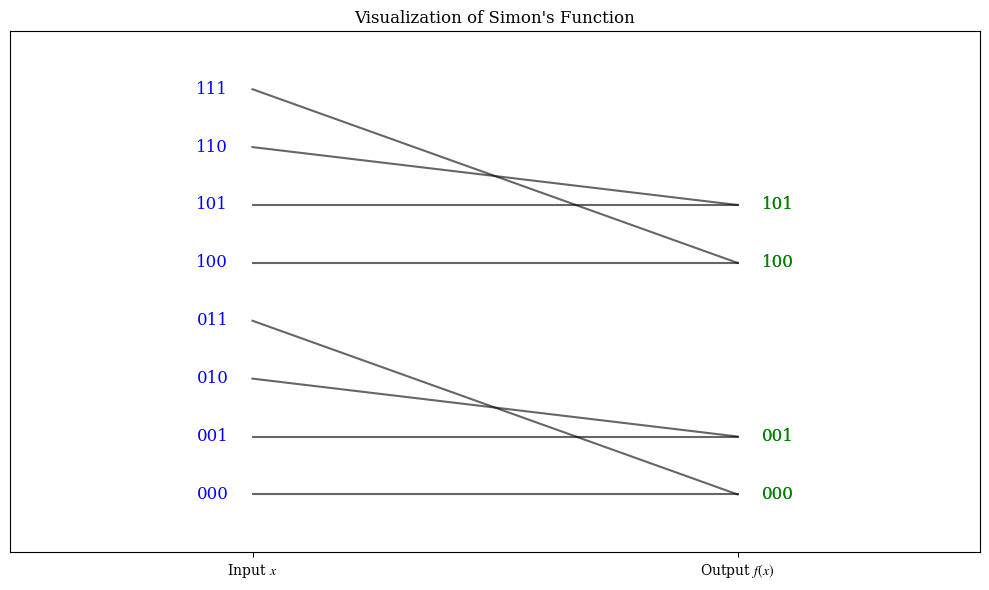

In [6]:
import matplotlib.pyplot as plt

inputs = [
    "000", "001", "010", "011",
    "100", "101", "110", "111"
]
outputs = [
    "000", "001", "001", "000",
    "100", "101", "101", "100"
]

unique_values = sorted(set(inputs + outputs))
y_map = {val: i for i, val in enumerate(unique_values)}

# Create the plot
plt.figure(figsize=(10, 6))
for x, fx in zip(inputs, outputs):
    plt.plot([0, 1], [y_map[x], y_map[fx]], 'k-', alpha=0.6)  # draw arrow from x to f(x)
    plt.text(-0.05, y_map[x], x, ha='right', va='center', fontsize=12, color='blue')
    plt.text(1.05, y_map[fx], fx, ha='left', va='center', fontsize=12, color='green')


plt.xticks([0, 1], ["Input $x$", "Output $f(x)$"])
plt.yticks([])
plt.title("Visualization of Simon's Function")
plt.xlim(-0.5, 1.5)
plt.ylim(-1, len(y_map))
plt.grid(False)
plt.tight_layout()
plt.show()


We can determine $s$ by inspecting any two pairs that map to the same output. For example $f(110) = f(101) = 101$. Therefore $110 \oplus s = 101 \Rightarrow s = 011$. 

Another example can be found [here](https://docs.classiq.io/latest/explore/algorithms/simon/simon/), although we are not going to implement this one in this notebook. 

> An example of a valid $f(x)$ function that satisfies the condition in Eq. (1) [$f(x) = f(y) \Leftrightarrow x \oplus y \in \{ 0,s \}$]:
$$
f(x) = \min(x, x \oplus s)
$$
Clearly, we have that:
> $$
f(x \oplus s) = \min(x \oplus s, (x \oplus s) \oplus s) = \min(x \oplus s, x) = f(x)
$$


Next we implement an instance of Simon's function as a quantum circuit: 

In [7]:
qc = QuantumCircuit(2)

In [8]:
def simon_oracle(secret_string):
    flag_bit = secret_string.find('1')
    n = len(secret_string)
    
    qc = QuantumCircuit(2*n,)
    for i in range(n):
        qc.cx(i,i+n)

    if flag_bit != -1:
        for index, bit_value in enumerate(secret_string):
            if bit_value == '1':
                qc.cx(flag_bit, index+n)
    return qc

In [9]:
# Create the oracle for s = "010"
oracle = simon_oracle("101")

# Draw the circuit
oracle.draw()

q_0: ──■──────────────■────■──
       │              │    │  
q_1: ──┼────■─────────┼────┼──
       │    │         │    │  
q_2: ──┼────┼────■────┼────┼──
     ┌─┴─┐  │    │  ┌─┴─┐  │  
q_3: ┤ X ├──┼────┼──┤ X ├──┼──
     └───┘┌─┴─┐  │  └───┘  │  
q_4: ─────┤ X ├──┼─────────┼──
          └───┘┌─┴─┐     ┌─┴─┐
q_5: ──────────┤ X ├─────┤ X ├
               └───┘     └───┘

In [10]:
secret_string = "101"
n = len(secret_string)
qc = QuantumCircuit(2*n, n)
qc.h(range(n))
qc.compose(simon_oracle(secret_string), inplace=True) # see: https://quantumcomputing.stackexchange.com/questions/32732/how-to-join-different-quantum-circuits-into-one-big-circuit-on-specific-qubits-i
qc.h(range(n))
qc.measure(range(n), range(n));

In [11]:
backend = Aer.get_backend('qasm_simulator')
result = backend.run(qc, shots=1024).result()
counts = result.get_counts()
print("Measurement outcome:", counts)

Measurement outcome: {'111': 282, '010': 249, '101': 239, '000': 254}


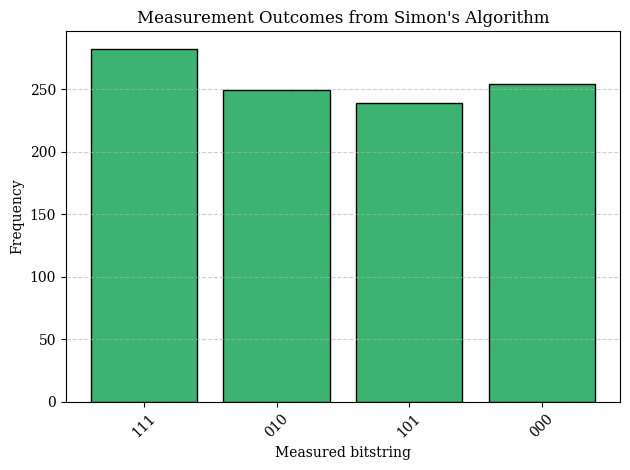

In [12]:
plt.figure()
plt.bar(counts.keys(), counts.values(), color='mediumseagreen', edgecolor='black')

plt.xlabel("Measured bitstring")
plt.ylabel("Frequency")
plt.title("Measurement Outcomes from Simon's Algorithm")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [13]:
bitstrings = list(counts.keys())
print(bitstrings)

['111', '010', '101', '000']


In [14]:
z_vectors = [np.array([int(bit) for bit in reversed(z)]) for z in bitstrings if z != '0'*len(z)]

# Define the field
GF2 = galois.GF(2)

# Convert to matrix over GF(2)
Z = GF2(z_vectors)

rank = np.linalg.matrix_rank(Z)

if rank < n-1:
    print("Not enough independent equations to uniquely determine the secret.")

if rank == n:
    print("s = 0^n")
    s_bits = '0'*n

if np.linalg.matrix_rank(Z) == len(z_vectors[0]) - 1:
    # There are enough linearly independent measurement vectors (rank = n - 1)
    # This guarantees that the nullspace is 1-dimensional and contains exactly two vectors: {0^n, s}
    # Therefore, we can conclusively recover the non-trivial secret string s (s ≠ 0)
    null_space = Z.null_space()
    s = null_space[0]
    s_bits = ''.join(str(int(b)) for b in s)

In [15]:
def solve_simon(secret_string):
    n = len(secret_string)
    qc = QuantumCircuit(2*n, n)
    qc.h(range(n))
    qc.compose(simon_oracle(secret_string), inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n));

    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(qc, shots=1024).result()
    counts = result.get_counts()

    bitstrings = list(counts.keys())

    z_vectors = [np.array([int(bit) for bit in reversed(z)]) for z in bitstrings if z != '0'*len(z)]
    
    # Define the field
    GF2 = galois.GF(2)
    
    # Convert to matrix over GF(2)
    Z = GF2(z_vectors)
    
    rank = np.linalg.matrix_rank(Z)
    
    if rank < n-1:
        print("Not enough independent equations to uniquely determine the secret.")
        return 
    
    if rank == n:
        s_bits = '0'*n
    
    if np.linalg.matrix_rank(Z) == len(z_vectors[0]) - 1:
        # There are enough linearly independent measurement vectors (rank = n - 1)
        # This guarantees that the nullspace is 1-dimensional and contains exactly two vectors: {0^n, s}
        # Therefore, we can conclusively recover the non-trivial secret string s (s ≠ 0)
        null_space = Z.null_space()
        s = null_space[0]
        s_bits = ''.join(str(int(b)) for b in s)

    return s_bits 

In [16]:
length_s = 4
secret_s = ''.join(random.choices('01', k = length_s))
solve_simon(secret_s)

'0110'

In [17]:
solve_simon("000")

'000'

Next, we can implement the classical evluation of $f$ to verify the correctness. 

In [18]:
def simons_classical_f(x_str, secret_s):
    n = len(secret_s)
    x = np.array([int(b) for b in x_str])
    s = np.array([int(b) for b in secret_s])
    flag_bit = secret_s.find('1')

    fx = x.copy()

    # If the flag bit is 1, XOR in the secret
    if flag_bit != -1 and x[flag_bit] == 1:
        fx = (fx + s) % 2  # XOR over GF(2)

    return ''.join(str(b) for b in fx)


In [19]:
def verify_secret(f, secret_s, trials = None):
    if trials is None:
        trials = 2 ** len(secret_s)
        
    candidate_secret = solve_simon(secret_s)
    length_s = len(candidate_secret)
    for i in range(trials):
        x_string = ''.join(random.choices('01', k = length_s)) # Note: not guaranteed to be unique, but sufficient for verification
        candidate_sol = f(x_string, candidate_secret)
        ground_truth = f(x_string, secret_s)
        if candidate_sol != ground_truth:
            print("Verification failed.")
            return False

    print(f"Verification passed.\nThe secret found by the Simon's algorithm is {candidate_secret}.\nThe actual secret is {secret_s}.")

In [20]:
length_s = 4
secret_s = ''.join(random.choices('01', k = length_s))

verify_secret(simons_classical_f, secret_s)

Verification passed.
The secret found by the Simon's algorithm is 1111.
The actual secret is 1111.


Note the classical post processing of Simon's algorithm involves solving a system of $n$ linear equations, which is typically upper bounded by a time complexity of $\mathcal{O}(n^3)$ using standard Gaussian elimination. This estimate serves as a simple upper bound for the sake of analysis. The quantum component of Simon's algorithm has a query complexity of $\mathcal{O}(n)$, so the overall runtime is dominated by the classical post processing step and is in $\mathcal{O}(n^3)$. Despite this, the algorithm still offers an exponential speedup compared to fully classical algorithms for solving Simon's problem. 

---
### Conclusion

In this notebook, we explored Simon's problem and examined a quantum algorithm that combined classical and quantum reources to achieve an exponential speedup over the best known classical approach. Simon's algorithm generates $n-1$ linearly independent equations, which were then processed classically to recover the hidden string. While the quantum query complexity was $\mathcal{O}(n)$, the classical post-processing step is upper bounded by $\mathcal{O}(n^3)$. In contrast, a fully classical algorithm for solving Simon's requires $\mathcal{O}(2^{\frac{n}{2}})$ time to expect a collision, based on a birthday paradox approxmiation. 

Finally, we end with a few questions for thought:
 - For a fixed $n$ and a nonzero secret $s \neq 0$, how many functions $f$ satisfy the promise conditions of Simon's problem? 
 - Can the post-processing step of quantum Simon's problem, which involves solving a system of linear equations classically, be replaced by a potentially faster quantum algorithm to reduce the total complexity of Simon's algorithm to $\mathcal{O}(n)$?
 - Is there a deterministic quantum algorithm for solving Simon's problem? See: [Brassard and Høyer, *An Exact Quantum Polynomial-Time Algorithm for Simon’s Problem* (1997)](https://arxiv.org/pdf/quant-ph/9704027). 

---
### Appendices
---
### Appendix 1: Biography
Daniel Ron Simon obtained his Ph.D. from the University of Toronto in 1993, with a dissertation titled On Defining and Achieving Cryptographic Security in a Multiparty Network. An entry for the dissertation is listed in the University of Toronto library catalog [here](https://librarysearch.library.utoronto.ca/permalink/01UTORONTO_INST/14bjeso/alma991106750064706196). 

Simon's problem, titled *On the Power of Quantum Computation*, was first published in 1994 in the Proceedings of the 35th IEEE Symposium on Foundations of Computer Science (FOCS). A revised and expanded version of the work was later published in the SIAM Journal on Computing in 1997 under the same title. The 1997 journal article includes the following note:

> Received by the editors February 7, 1996; accepted for publication (in revised form) December 2, 1996. A preliminary version of this paper appeared in Proceedings of the 35th IEEE Symposium on the Foundations of Computer Science (FOCS), Santa Fe, NM, Shafi Goldwasser, ed., IEEE Computer Society Press, Los Alamitos, CA, 1994, pp. 116-123.

After completing his Ph.D., Simon worked at Microsoft Research, where he contributed to areas such as cryptography. Beginning in the late 2010s, he has held a role as Principal Security Engineer in the AWS Cryptography group at Amazon Web Services, focusing on cryptography and information security.

---
### Appendix 2: References and Suggested Readings

1. D. R. Simon, *On the Power of Quantum Computation*,  in Proceedings of the 35th Annual IEEE Symposium on Foundations of Computer Science (FOCS),  
Santa Fe, NM, USA, 1994, pp. 116–123. DOI: [10.1109/SFCS.1994.365701](https://doi.org/10.1109/SFCS.1994.365701)

2. Daniel Simon. *On the Power of Quantum Computation.* SIAM Journal on Computing, Vol. 26, No. 5, pp. 1474–1483, 1997. DOI: [10.1137/S0097539796298637](https://epubs.siam.org/doi/10.1137/S0097539796298637).<sup>1</sup>

3. Richard Cleve. *Classical Lower Bound for Simon’s Problem.* Lecture Notes, University of Waterloo. [PDF](https://cs.uwaterloo.ca/~cleve/courses/F11CS667/SimonClassicalLB.pdf). 

4. Rocco A. Servedio and Steven J. Gortler. *Equivalences and Separations between Quantum and Classical Learnability.*  Columbia University. [PDF](https://www.cs.columbia.edu/~rocco/Public/SG_041291_2.pdf).

5. A. Klappenecker (Texas A&M). *Simon’s Algorithm: Classical Post-Processing.* [Lecture Notes](https://people.engr.tamu.edu/andreas-klappenecker/csce640-f14/simon2.pdf). 

6. Guangya Cai and Daowen Qiu. *Optimal Separation in Exact Query Complexities for Simon's Problem.* Journal of Computer and System Sciences, Volume 97, 2018, Pages 83–93. DOI: [10.1016/j.jcss.2018.05.001](https://doi.org/10.1016/j.jcss.2018.05.001)  


7. Hans Zantema.  *Complexity of Simon's Problem in the Classical Sense.*  arXiv preprint, arXiv:2211.01776, 2022. URL: [arxiv.org/abs/2211.01776](https://arxiv.org/abs/2211.01776).

8. Xavier Bonnetain.  *Tight Bounds for Simon's Algorithm.*  Cryptology ePrint Archive, Report 2020/919, 2020.  URL: [eprint.iacr.org/2020/919](https://eprint.iacr.org/2020/919).

9. StackExchange Discussion: *Classical Complexity for Simon’s Problem.* https://quantumcomputing.stackexchange.com/questions/5041/classical-complexity-for-simons-problem. 

10. Amazon Braket. *Simon's Algorithm*.   GitHub Repository, Amazon Braket Examples. 2021. [Amazon Braket Notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/5240025f7f7e8ad14944309a2de263fa3a10bdd3/examples/advanced_circuits_algorithms/Simons_Algorithm/Simons_Algorithm.ipynb).

11. Grant Salton, Daniel Simon, and Cedric Lin. *Exploring Simon’s Algorithm with Daniel Simon.*  AWS Quantum Technologies Blog, October 11, 2021. [Amazon Blog](https://aws.amazon.com/blogs/quantum-computing/simons-algorithm/).

12. Classiq. *Simon’s Algorithm.*  Classiq Technologies. [Classiq Notebook](https://docs.classiq.io/latest/explore/algorithms/simon/simon/#quantum-part_1).

13. Ryan LaRose. *Lecture Notes: Simon’s Algorithm.* [PDF](https://www.ryanlarose.com/uploads/1/1/5/8/115879647/simon.pdf).


<sup>1</sup> The 1997 SIAM Journal paper builds on the 1994 FOCS conference version. As stated in the 1997 paper: 
*"A preliminary version of this paper appeared in Proceedings of the 35th IEEE Symposium on the Foundations of Computer Science (FOCS), Santa Fe, NM, Shafi Goldwasser, ed., IEEE Computer Society Press, Los Alamitos, CA, 1994, pp. 116-123."*